<a href="https://colab.research.google.com/github/hafsaAit/Machine-learning-models/blob/main/Models_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sktime

In [4]:
!pip install prophet

In [ ]:
pip install feature_engine

In [ ]:
pip install skforecast


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from math import sqrt
from pandas import date_range
from feature_engine.datetime import DatetimeFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from skforecast.ForecasterAutoreg import ForecasterAutoreg


### DataFrame

In [8]:
df = pd.read_excel("/content/drive/MyDrive/stage/data (journaliers)/RAIB ET LBEN JOURNALIERS.xlsx")

print(df)
print(df.columns)


     Jour Fiscal  Ventes Totales TTC
0     2011/12/14               35770
1     2011/12/15               51009
2     2011/12/16               97948
3     2011/12/17               36931
4     2011/12/18               32585
...          ...                 ...
4180  2023/06/21               85658
4181  2023/06/22              119798
4182  2023/06/23              183712
4183  2023/06/24              114690
4184  2023/06/25                   0

[4185 rows x 2 columns]
Index(['Jour Fiscal', 'Ventes Totales TTC'], dtype='object')


In [9]:
df['Jour Fiscal'] = pd.to_datetime(df['Jour Fiscal'])


In [10]:
df.set_index('Jour Fiscal', inplace=True)


In [11]:
df = df.asfreq('D')

In [12]:
df['Ventes Totales TTC'] = df['Ventes Totales TTC'].replace(0, float('nan'))


In [13]:
df['Ventes Totales TTC'] = df['Ventes Totales TTC'].fillna(method='ffill')

<ipython-input-13-f90f1f41f502>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Ventes Totales TTC'] = df['Ventes Totales TTC'].fillna(method='ffill')


In [14]:
df

,Ventes Totales TTC
Jour Fiscal,
2011-12-14,35770.0
2011-12-15,51009.0
2011-12-16,97948.0
2011-12-17,36931.0
2011-12-18,32585.0
...,...
2023-06-21,85658.0
2023-06-22,119798.0
2023-06-23,183712.0


In [15]:
date_fin_train = '2022-10-01'
df_train = df[df.index < date_fin_train]
df_test = df[df.index >= date_fin_train]

### Linear regression model

In [16]:
df[f'moving_avg_{3}'] = df['Ventes Totales TTC'].rolling(window=3).mean().shift(1)

In [17]:
df[f'moving_avg_{6}'] = df['Ventes Totales TTC'].rolling(window=6).mean().shift(1)

In [18]:
df[f'moving_avg_{12}'] = df['Ventes Totales TTC'].rolling(window=12).mean().shift(1)

In [19]:
df

,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12
Jour Fiscal,,,,
2011-12-14,35770.0,NaN,NaN,NaN
2011-12-15,51009.0,NaN,NaN,NaN
2011-12-16,97948.0,NaN,NaN,NaN
2011-12-17,36931.0,61575.666667,NaN,NaN
2011-12-18,32585.0,61962.666667,NaN,NaN
...,...,...,...,...
2023-06-21,85658.0,65046.666667,96808.833333,89693.666667
2023-06-22,119798.0,71841.666667,91463.000000,82939.750000
2023-06-23,183712.0,89165.666667,83570.000000,85543.666667


In [20]:
# @title Création des lag
df['sale_lastmonth'] = df['Ventes Totales TTC'].shift(1)
df['sale_3Monthsback'] = df['Ventes Totales TTC'].shift(3)
df['sale_6Monthsback'] = df['Ventes Totales TTC'].shift(6)
df['sale_12Monthsback'] = df['Ventes Totales TTC'].shift(12)

In [21]:
df["Date"] = df.index
df.head()

,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,Date
Jour Fiscal,,,,,,,,,
2011-12-14,35770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-14
2011-12-15,51009.0,NaN,NaN,NaN,35770.0,NaN,NaN,NaN,2011-12-15
2011-12-16,97948.0,NaN,NaN,NaN,51009.0,NaN,NaN,NaN,2011-12-16
2011-12-17,36931.0,61575.666667,NaN,NaN,97948.0,35770.0,NaN,NaN,2011-12-17
2011-12-18,32585.0,61962.666667,NaN,NaN,36931.0,51009.0,NaN,NaN,2011-12-18


In [22]:
df["year"] = df["Date"].dt.year
df["quarter"] = df["Date"].dt.quarter
df["month"] = df["Date"].dt.month

df["DAY"] = df["Date"].dt.day


df.head()


,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,Date,year,quarter,month,DAY
Jour Fiscal,,,,,,,,,,,,,
2011-12-14,35770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-14,2011,4,12,14
2011-12-15,51009.0,NaN,NaN,NaN,35770.0,NaN,NaN,NaN,2011-12-15,2011,4,12,15
2011-12-16,97948.0,NaN,NaN,NaN,51009.0,NaN,NaN,NaN,2011-12-16,2011,4,12,16
2011-12-17,36931.0,61575.666667,NaN,NaN,97948.0,35770.0,NaN,NaN,2011-12-17,2011,4,12,17
2011-12-18,32585.0,61962.666667,NaN,NaN,36931.0,51009.0,NaN,NaN,2011-12-18,2011,4,12,18


In [23]:
df.drop(columns=['Date'], inplace = True)

df.head()

,Ventes Totales TTC,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,year,quarter,month,DAY
Jour Fiscal,,,,,,,,,,,,
2011-12-14,35770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,4,12,14
2011-12-15,51009.0,NaN,NaN,NaN,35770.0,NaN,NaN,NaN,2011,4,12,15
2011-12-16,97948.0,NaN,NaN,NaN,51009.0,NaN,NaN,NaN,2011,4,12,16
2011-12-17,36931.0,61575.666667,NaN,NaN,97948.0,35770.0,NaN,NaN,2011,4,12,17
2011-12-18,32585.0,61962.666667,NaN,NaN,36931.0,51009.0,NaN,NaN,2011,4,12,18


In [24]:
df.dropna(inplace=True)


In [25]:
predict_start_date = df_test.index[0]
predict_end_date = df_test.index[-1]

In [26]:
# @title Variables indépendantes et dépendantes

X_train = df.loc[df.index < predict_start_date, df.columns != 'Ventes Totales TTC']
y_train = df.loc[df.index < predict_start_date, 'Ventes Totales TTC']

X_test = df.loc[(df.index >= predict_start_date) & (df.index <= predict_end_date), df.columns != 'Ventes Totales TTC']
y_test = df.loc[(df.index >= predict_start_date) & (df.index <= predict_end_date), 'Ventes Totales TTC']


In [27]:
# @title Linear Regression
lin_model = LinearRegression()

In [28]:
lin_model.fit(X_train, y_train)


LinearRegression()

In [29]:
predictions = lin_model.predict(X_test )

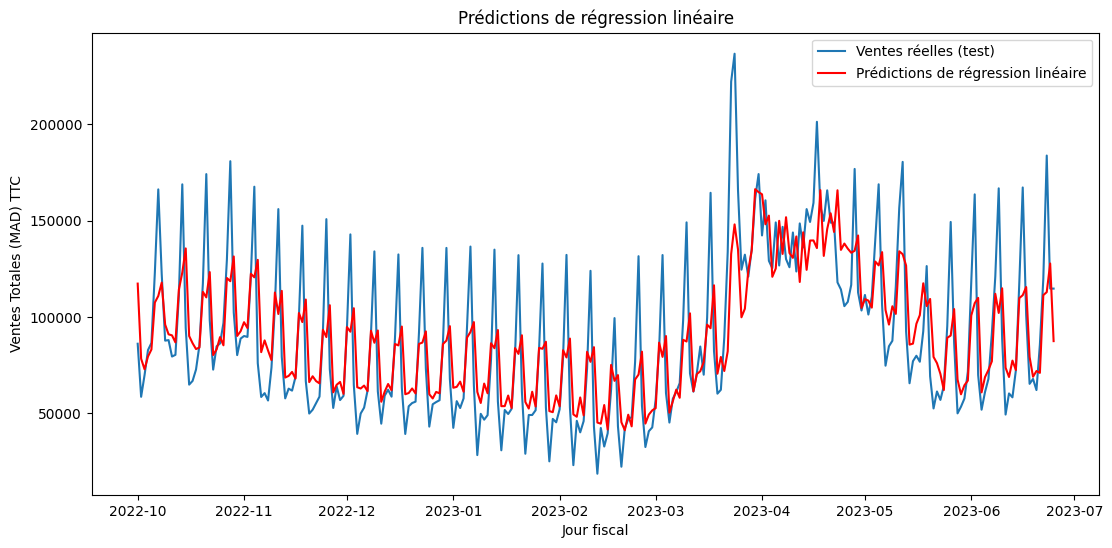

In [30]:
# @title Previsions Linear Regression
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, predictions, label='Prédictions de régression linéaire', color='red')

plt.title('Prédictions de régression linéaire')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()


In [31]:
# @title Linear Regression RMSE
LinearRegression_rmse = mean_squared_error(y_test, predictions, squared=False)

Lin_rmse_rounded = round(LinearRegression_rmse, 2)
print(f'RMSE: {Lin_rmse_rounded}')

RMSE: 26636.04


### RANDOM FOREST MODEL

In [32]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [33]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
rf_predictions = rf_model.predict(X_test)


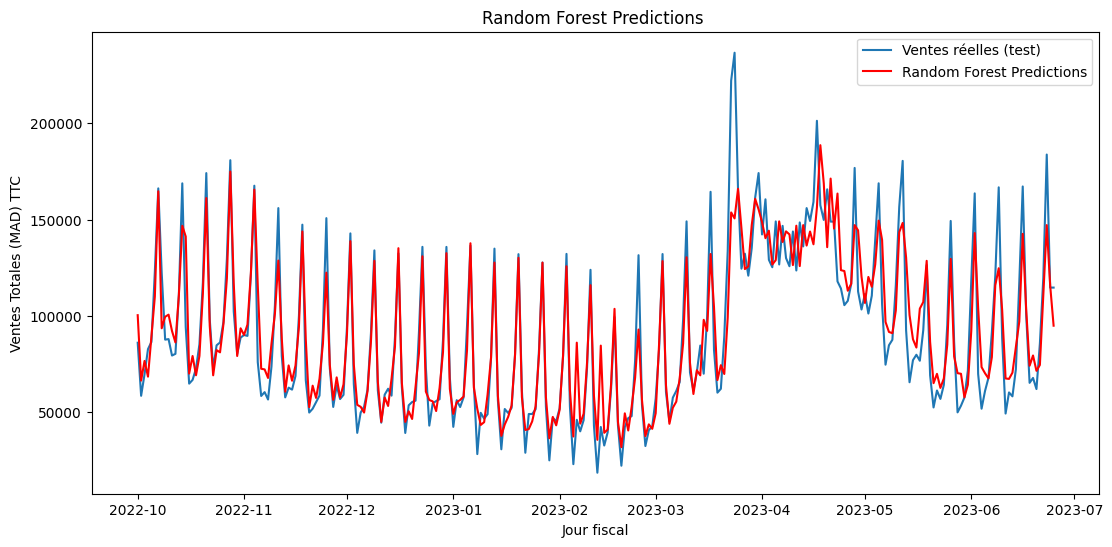

In [35]:
# @title Prévisions Random Forest
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='RED')

plt.title('Random Forest Predictions ')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [36]:
# @title Random Forest Regression RMSE
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
rf_rmse_rounded = round(rf_rmse, 2)
print(f'RMSE pour la forêt aléatoire : {rf_rmse_rounded}')

RMSE pour la forêt aléatoire : 16189.84


### XG BOOST MODEL

In [37]:
# @title Convertir les données au format DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [38]:
# @title les paramètres du modèle XGBoost

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
    }

In [39]:
# @title Entraîner le modèle XGBoost
num_round = 100
xgb_model = xgb.train(params, dtrain, num_round)

In [40]:
# @title XGBoost Model Predictions
xgb_predictions = xgb_model.predict(dtest)

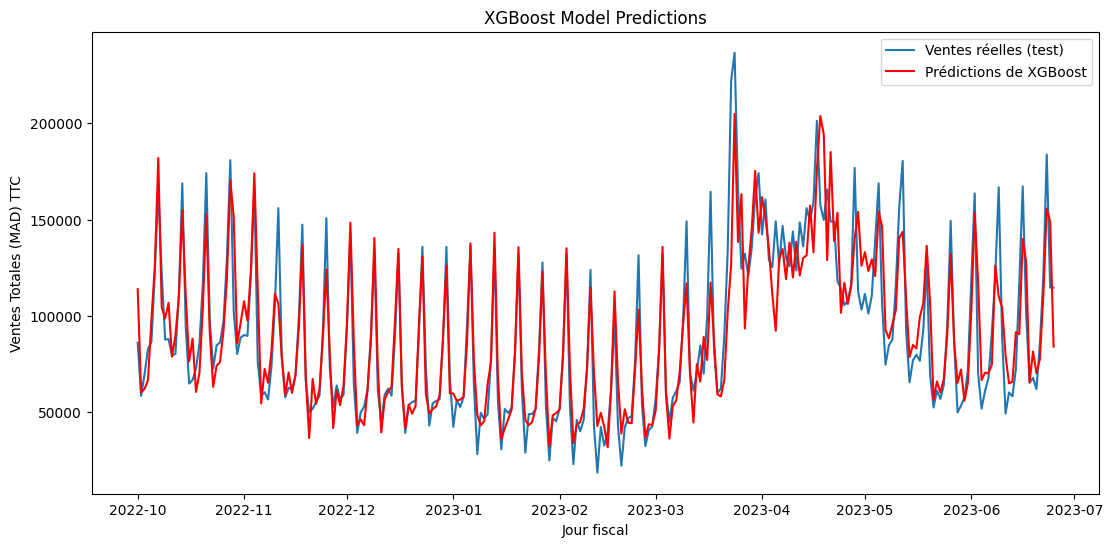

In [41]:


plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, xgb_predictions, label='Prédictions de XGBoost', color='red')

plt.title('XGBoost Model Predictions')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

In [42]:
# @title  RMSE pour XGBoost
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_rmse_rounded = round(xgb_rmse, 2)
print(f'RMSE pour XGBoost : {xgb_rmse_rounded}')

RMSE pour XGBoost : 17967.25


### prevision recurssive

In [43]:
X_pred = X_test.copy()


In [44]:
num_points = len(X_pred)

In [ ]:
num_points

In [ ]:
for i in range(num_points):

    pred = lin_model.predict(X_pred.iloc[[i]])


    if i+1 < num_points:
        X_pred.iloc[i+1][-7] = pred[0]

In [46]:
X_pred

,moving_avg_3,moving_avg_6,moving_avg_12,sale_lastmonth,sale_3Monthsback,sale_6Monthsback,sale_12Monthsback,year,quarter,month,DAY
Jour Fiscal,,,,,,,,,,,
2022-10-01,112552.333333,87670.500000,96606.750000,157508.0,70659.0,63030.0,88357.0,2022,4,10,1
2022-10-02,117695.000000,91513.333333,96417.583333,86087.0,109490.0,65899.0,77711.0,2022,4,10,2
2022-10-03,100716.000000,90289.000000,94821.083333,58553.0,157508.0,59437.0,90905.0,2022,4,10,3
2022-10-04,71488.000000,92020.166667,93064.333333,69824.0,86087.0,70659.0,110944.0,2022,4,10,4
2022-10-05,70386.000000,94040.500000,90717.416667,82781.0,58553.0,109490.0,164307.0,2022,4,10,5
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,65046.666667,96808.833333,89693.666667,62041.0,65273.0,117733.0,166705.0,2023,2,6,21
2023-06-22,71841.666667,91463.000000,82939.750000,85658.0,67826.0,167156.0,88551.0,2023,2,6,22
2023-06-23,89165.666667,83570.000000,85543.666667,119798.0,62041.0,100824.0,49345.0,2023,2,6,23


In [155]:
recursive_predictions = X_pred['sale_lastmonth'].values


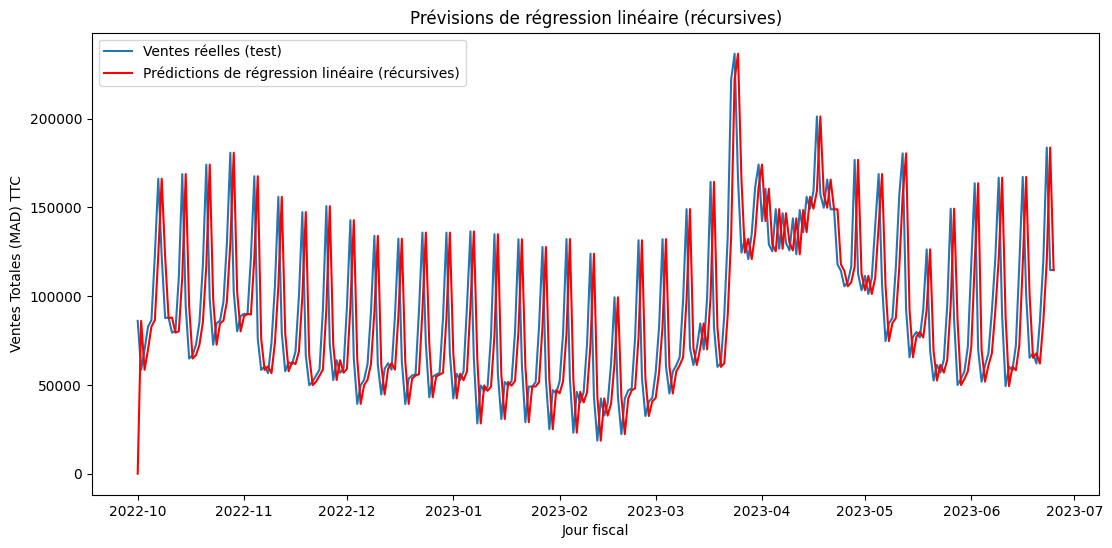

In [156]:
plt.figure(figsize=(13, 6))
plt.plot(y_test.index, y_test, label='Ventes réelles (test)')
plt.plot(y_test.index, recursive_predictions, label='Prédictions de régression linéaire (récursives)', color='RED')

plt.title('Prévisions de régression linéaire (récursives)')
plt.xlabel('Jour fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.legend()
plt.show()

### Recursive multi-step forecasting using random forest


In [59]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=365
)

forecaster.fit(y=df_train['Ventes Totales TTC'])




In [60]:
# Prédictions
steps = len(df_test)
rf_recursive_predictions = forecaster.predict(steps=steps)


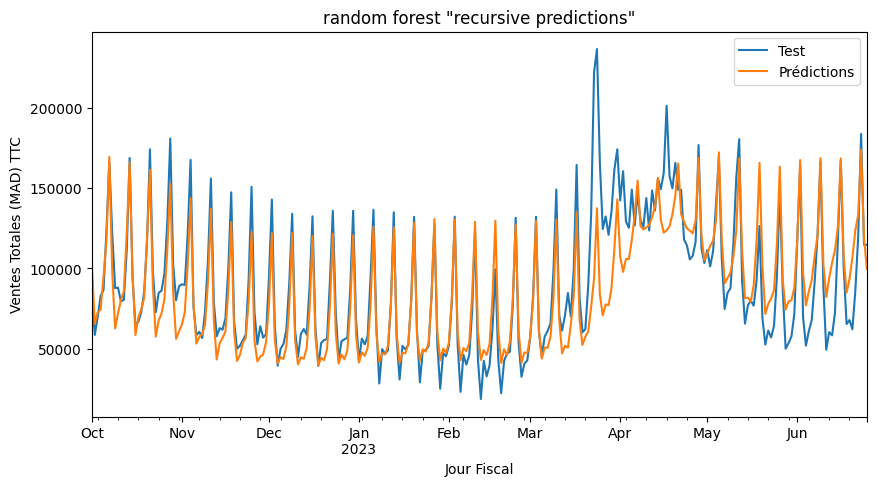

In [61]:
plt.figure(figsize=(10, 5))

df_test['Ventes Totales TTC'].plot(label='Test')
rf_recursive_predictions.plot(label='Prédictions')
plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('random forest "recursive predictions"')
plt.legend()
plt.show()

In [71]:
# @title RMSE

mse_rf = mean_squared_error(y_true=y_test, y_pred=rf_recursive_predictions)
rmse_rf = sqrt(mse_rf)
rmse_rounded = round(rmse_rf, 2)

print(f"RMSE: {rmse_rounded}")

RMSE: 21152.62


### Prédictions récursives XGBoost

In [ ]:

# Créer et entraîner le modèle XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xgb_model.fit(X_train, y_train)



In [63]:
forecaster_xgb = ForecasterAutoreg(regressor=xgb_model, lags=365)


forecaster_xgb.fit(y=y_train)


In [64]:

# Prédictions récursives multi-étapes
steps = len(y_test)
xgb_recursive_predictions = forecaster_xgb.predict(steps=steps)


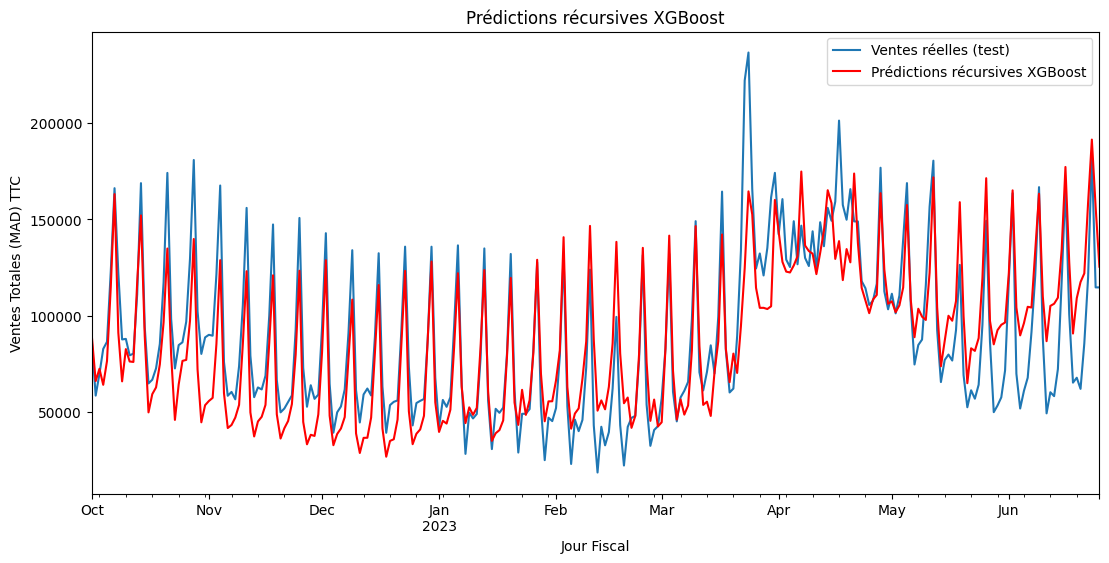

In [65]:
plt.figure(figsize=(13, 6))
y_test.plot(label='Ventes réelles (test)')
xgb_recursive_predictions.plot(label='Prédictions récursives XGBoost', color='red')

plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('Prédictions récursives XGBoost')
plt.legend()
plt.show()


In [70]:
# @title RMSE

mse_xgb = mean_squared_error(y_true=y_test, y_pred=xgb_recursive_predictions)
rmse_xgb = sqrt(mse_xgb)
rmse_rounded = round(rmse_xgb, 2)

print(f"RMSE: {rmse_rounded}")

RMSE: 21742.49


### Prédictions récursives de régression linéaire


In [72]:

# Initialiser le modèle ForecasterAutoreg
forecaster_lin = ForecasterAutoreg(regressor=lin_model, lags=365)


In [73]:
forecaster_lin.fit(y=y_train)


In [74]:
# Prédictions récursives multi-étapes
steps = len(y_test)
linear_recursive_predictions = forecaster_lin.predict(steps=steps)


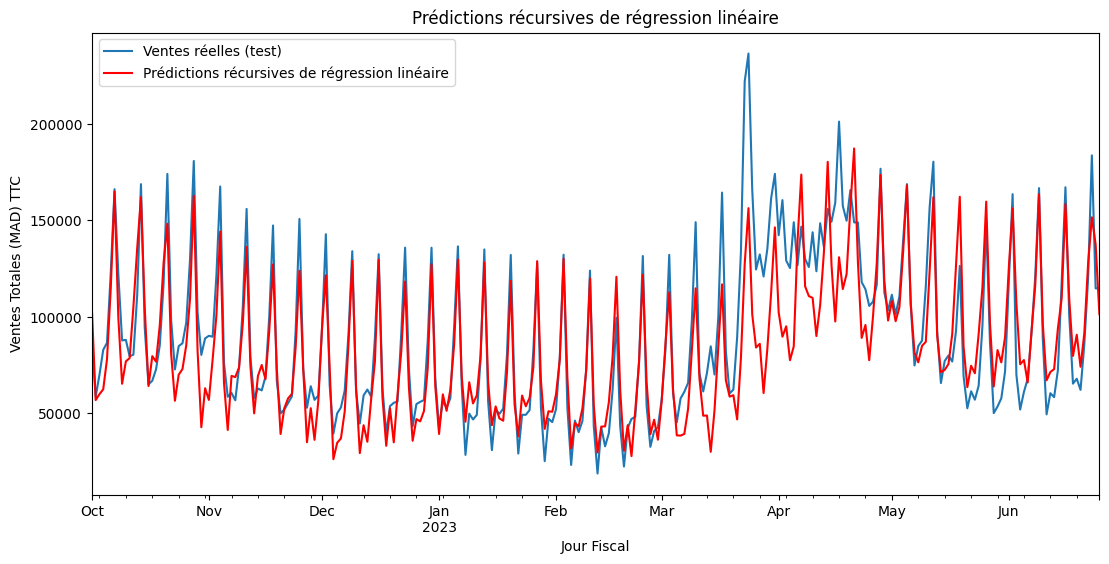

In [75]:

plt.figure(figsize=(13, 6))
y_test.plot(label='Ventes réelles (test)')
linear_recursive_predictions.plot(label='Prédictions récursives de régression linéaire', color='red')

plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('Prédictions récursives de régression linéaire')
plt.legend()
plt.show()


In [76]:
# @title RMSE
mse = mean_squared_error(y_true=y_test, y_pred=linear_recursive_predictions)
rmse = sqrt(mse)
rmse_rounded = round(rmse, 2)

print(f"RMSE: {rmse_rounded}")

RMSE: 21476.09
